### LOAD THE LIBRARIES

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew #for some statistics
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

# for ML Modelling
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error,confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn import tree

C:\Users\errit\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


### LOAD ALL DATA SPREADSHEETS

train_df = pd.read_csv("application_train.csv")
test_df = pd.read_csv("application_test.csv")
bureau_df = pd.read_csv("bureau.csv")
bureau_balance_df = pd.read_csv("bureau_balance.csv")
cc_balance_df = pd.read_csv("credit_card_balance.csv")
install_pmt_df = pd.read_csv("installments_payments.csv")
poscash_bal_df = pd.read_csv("POS_CASH_balance.csv")
prv_app_df = pd.read_csv("previous_application.csv")

Approach - 

1. Load application_train.csv
2. Tackle Missing Values-
   Record missing value attributes and remove the missing values from data frame 
   Perform missing value attribute analysis and impute the values using imputer class
3. Feature Engineering-   
   Analyze attributes one by one and try to realise the hypothesis in relation with other attributes using domain understanding
   Note the obervations 
   Create domain features as many as possible in a seperate dataframe
   Load Featuretools and create mathematical features and load it in the seperate dataframe
   Analyze all the features that are strongly correlated with the response and remove others
   Remove multicollinearity
4. Decide to remove outliers or keep them as is if they are good for model.
5. Tackle imbalance in targets using the SMOTE, Random UnderSampling, Random OverSampling
6. Fit various base models on it using pipeline


All of the modelling should be done using the customized methods or see if there are standard methods in libraries already available


    
   

#### 1. Load application_train.csv

In [2]:
#del train_df
train_df = pd.read_csv("application_train.csv")

In [3]:
def dataframeinfo(df):
    print("the shape of the dataset is:", df.shape)
    print("********************************************************************************")
    print("the datatypes are as \n",df.dtypes)
    print("********************************************************************************")
    print(df.head())
    print("********************************************************************************")
    print(df.info())
    print("********************************************************************************")
    print(df.describe())
    print("********************************************************************************")
    print("count of missing values by attribute:\n",df.isna().sum())

In [4]:
dataframeinfo(train_df)

the shape of the dataset is: (307511, 122)
********************************************************************************
the datatypes are as 
 SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
FLAG_OWN_REALTY                object
CNT_CHILDREN                    int64
AMT_INCOME_TOTAL              float64
AMT_CREDIT                    float64
AMT_ANNUITY                   float64
AMT_GOODS_PRICE               float64
NAME_TYPE_SUITE                object
NAME_INCOME_TYPE               object
NAME_EDUCATION_TYPE            object
NAME_FAMILY_STATUS             object
NAME_HOUSING_TYPE              object
REGION_POPULATION_RELATIVE    float64
DAYS_BIRTH                      int64
DAYS_EMPLOYED                   int64
DAYS_REGISTRATION             float64
DAYS_ID_PUBLISH                 int64
OWN_CAR_AGE                   float64
FLAG_MOBIL       

count of missing values by attribute:
 SK_ID_CURR                         0
TARGET                             0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                       12
AMT_GOODS_PRICE                  278
NAME_TYPE_SUITE                 1292
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   202929
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0

In [12]:
target = train_df.TARGET
x_df = train_df.drop(train_df[['TARGET']],axis=1)

In [6]:
x = x_df.isna().sum()

In [7]:
missing_values_feats = x[x>0].index

# create universal imputer
1. Drop rows if null values less than 5 percent
2. Impute with one value (mean,median,mode)
3. Impute based on conditions
4. Multivariate imputations - Check if the variables are strongly correlated with any other variable in the data set. If yes then use the multivariate imputation 'IterativeImputer' and then use the correlated column to define the imputations. If both are na then need to think of alternatives.


In [8]:
def distinct_feats(df):
    num_feats = [x for x in df.columns if df[x].dtypes!='object']
    cat_feats = [x for x in df.columns if df[x].dtypes=='object']
    return (num_feats,cat_feats)


In [9]:
num_feats,cat_feats = distinct_feats(train_df)

In [10]:
def is_mean_imputable(df, feature,skew_threshold,kurt_threshold):
    if df[feature].dtypes!='object':
        if abs(df[feature].skew())<=skew_threshold and abs(df[feature].kurt()) <=kurt_threshold:
            print('For Feature',feature,'Skew:',float(df[feature].skew()),',Kurt:',float(df[feature].kurt()))
            return 1
        else: 
            return 0

def is_median_imputable(df, feature,skew_threshold,kurt_threshold):
    if df[feature].dtypes!='object':
        if abs(df[feature].skew())<=skew_threshold and abs(df[feature].kurt()) <=kurt_threshold:
            print('For Feature',feature,'Skew:',float(df[feature].skew()),',Kurt:',float(df[feature].kurt()))
            return 1
        else: 
            return 0


# function to drop na values and impute the values with mean and median whereever required
def impute_values (df, misval_list,max_na_threshold,skew_threshold=0.1,kurt_threshold=1, imp_type=True):
    for feat in misval_list:
        if imp_type == True:
            misval_per = (df[feat].isna().sum()/df[feat].size)*100
            #print(feat,":",misval_per)
            if misval_per <= 5 and misval_per != 0.0:
                print('Delete for feature {} with {} na rows with {} missing percentage values'.format(feat,df[feat].isna().sum(),misval_per))
                df = df.drop(df[df[feat].isna()].index)
            elif misval_per >= max_na_threshold:
                print('Dropping feature {} with {} missing percentage values'.format(feat,misval_per))
                df = df.drop(df[[feat]],axis=1) 
            #df = impute_univariate(df, mean_list, median_list, mode_list, feat)
            elif is_mean_imputable(df,feat,skew_threshold,kurt_threshold) == 1:
                    df[feat] = df[feat].fillna(df[feat].mean())
                    print('Imputing',feat,'with mean value as',df[feat].mean())
    return (df)

In [13]:
imp_df = impute_values(x_df,missing_values_feats,80)

Delete for feature AMT_ANNUITY with 12 na rows with 0.003902299429939092 missing percentage values
Delete for feature AMT_GOODS_PRICE with 278 na rows with 0.09040679807088804 missing percentage values
Delete for feature NAME_TYPE_SUITE with 1014 na rows with 0.3300555626080249 missing percentage values
For Feature EXT_SOURCE_1 Skew: -0.06902892139118963 ,Kurt: -0.9652200514432399
Imputing EXT_SOURCE_1 with mean value as 0.5022133410876205
Delete for feature EXT_SOURCE_2 with 659 na rows with 0.21521389125656828 missing percentage values
Delete for feature OBS_30_CNT_SOCIAL_CIRCLE with 1017 na rows with 0.33284459397541466 missing percentage values


In [14]:
imp_df.isna().sum()

SK_ID_CURR                         0
NAME_CONTRACT_TYPE                 0
CODE_GENDER                        0
FLAG_OWN_CAR                       0
FLAG_OWN_REALTY                    0
CNT_CHILDREN                       0
AMT_INCOME_TOTAL                   0
AMT_CREDIT                         0
AMT_ANNUITY                        0
AMT_GOODS_PRICE                    0
NAME_TYPE_SUITE                    0
NAME_INCOME_TYPE                   0
NAME_EDUCATION_TYPE                0
NAME_FAMILY_STATUS                 0
NAME_HOUSING_TYPE                  0
REGION_POPULATION_RELATIVE         0
DAYS_BIRTH                         0
DAYS_EMPLOYED                      0
DAYS_REGISTRATION                  0
DAYS_ID_PUBLISH                    0
OWN_CAR_AGE                   200912
FLAG_MOBIL                         0
FLAG_EMP_PHONE                     0
FLAG_WORK_PHONE                    0
FLAG_CONT_MOBILE                   0
FLAG_PHONE                         0
FLAG_EMAIL                         0
O

Step 1. Drop rows if null values less than 5 percent and Drop columsn with null values more than 80%


In [15]:
x = imp_df.isna().sum()
mis = x[x>0].index

In [16]:
imp_df[mis].isna().sum()

OWN_CAR_AGE                     200912
OCCUPATION_TYPE                  95435
EXT_SOURCE_3                     60251
APARTMENTS_AVG                  154677
BASEMENTAREA_AVG                178332
YEARS_BEGINEXPLUATATION_AVG     148686
YEARS_BUILD_AVG                 202604
COMMONAREA_AVG                  212870
ELEVATORS_AVG                   162459
ENTRANCES_AVG                   153468
FLOORSMAX_AVG                   151677
FLOORSMIN_AVG                   206726
LANDAREA_AVG                    180937
LIVINGAPARTMENTS_AVG            208259
LIVINGAREA_AVG                  152985
NONLIVINGAPARTMENTS_AVG         211544
NONLIVINGAREA_AVG               168187
APARTMENTS_MODE                 154677
BASEMENTAREA_MODE               178332
YEARS_BEGINEXPLUATATION_MODE    148686
YEARS_BUILD_MODE                202604
COMMONAREA_MODE                 212870
ELEVATORS_MODE                  162459
ENTRANCES_MODE                  153468
FLOORSMAX_MODE                  151677
FLOORSMIN_MODE           

In [24]:
imp_df[imp_df['OWN_CAR_AGE']>50]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
85,100100,Cash loans,M,Y,Y,2,202500.000,796396.500,38443.500,643500.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,2.000
134,100156,Cash loans,F,Y,N,2,157500.000,945000.000,39127.500,945000.000,...,0,0,0,0,0.000,0.000,0.000,1.000,0.000,1.000
237,100275,Cash loans,F,Y,Y,0,108000.000,646920.000,18670.500,540000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000
272,100315,Cash loans,F,Y,Y,1,121500.000,288873.000,21064.500,238500.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
369,100425,Cash loans,F,Y,Y,2,90000.000,688500.000,20259.000,688500.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
415,100479,Revolving loans,M,Y,Y,0,90000.000,180000.000,9000.000,180000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
425,100491,Cash loans,M,Y,N,0,193500.000,314100.000,17167.500,225000.000,...,0,0,0,0,nan,nan,nan,nan,nan,nan
466,100536,Cash loans,F,Y,Y,2,99000.000,787131.000,42066.000,679500.000,...,0,0,0,0,0.000,0.000,0.000,2.000,0.000,4.000
580,100666,Cash loans,M,Y,Y,0,135000.000,422451.000,19822.500,297000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
636,100726,Cash loans,M,Y,N,0,202500.000,450000.000,17271.000,450000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


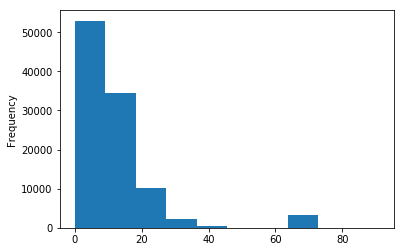

In [23]:
imp_df.OWN_CAR_AGE.plot.hist()

In [162]:
imp_df.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=105)